<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: EOF analysis of daily zonal wind</h1>
<h3>Usung NCEP reanalysis data with the xarray package</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Author: Wei-Ming Tsai
### Date: 04/10/2018

This notebook shows EOF applications on 7-year daily zonal wind over 45N-45S and a figure.
A powerful package 'Xarray' can easily read netcdf files, select dimensions you want (time, lat, lon), and process data with some
analysis, but read variables are not in the form of 'array'. More explorations are needed for this tool later.

The EOF decompostion by SDV returns 3 matrices according to the covariance matrix of the variable and the combinition of them construct PCs and EOFs
The first EOF explains the most variances and how many EOFs we get depends on how many spatial grids we use
In some cases, only 3-4 EOFs are needed for reconstructing covariance maxtrix which explains more than 90% varainces.

PCs illustrate the amplitude of corresponding EOFs : Spatial structures are determined by EOFs, and temporal variations are inferred from PCs

A EOF decomposition of figure is shown, but the extremely long url is kind of terrible.
### Links to subsections
1. <a href="#opendap">OpenDAP: from a URL not a file</a>


### Part I: EOF Analysis of Zonal Wind over the Tropics

In [196]:
%matplotlib inline
import os as os
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
#from netCDF4 import Dataset
from datetime import datetime
os.chdir('/Users/willytsai/MPO624_data/data');

dataset=xr.open_dataset('uwnd.day.2010_2016.45NS.nc'); # read ncfile 
dataset

<xarray.Dataset>
Dimensions:  (lat: 37, lev: 17, lon: 144, time: 2555)
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float64 -45.0 -42.5 -40.0 -37.5 -35.0 -32.5 -30.0 -27.5 ...
  * lev      (lev) float64 1e+03 925.0 850.0 700.0 600.0 500.0 400.0 300.0 ...
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 2010-01-03 ...
Data variables:
    u        (time, lev, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.5 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Tue Jan 30 22:51:28 2018: cdo mergetime uwnd.day.2010.45NS....
    CDO:          Climate Data Operators version 1.6.5 (http://code.zmaw.de/p...

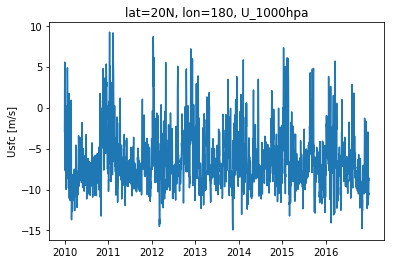

In [197]:
udata1 = dataset.sel(lat=20,lon=180,lev=1000,method='nearest') # select domain 
plt.plot(udata1.u)
plt.title('lat=20N, lon=180, U_1000hpa')
plt.xticks(np.arange(0,2555,365),np.arange(2010,2017,1));
plt.ylabel('Usfc [m/s]')
plt.show()

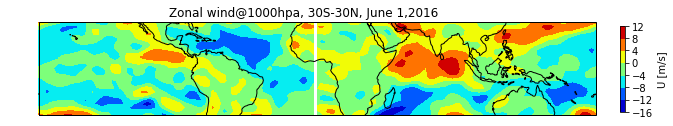

In [212]:
# CartoPy map plot at one time
import cartopy.crs as ccrs
import cartopy.feature as cfeat

fig = plt.figure(figsize=(11,4))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# Sets the extent to cover the whole globe
# ax.set_global()

#udata=dataset.sel(time=slice(datetime(2016,6,1),datetime(2016,8,30)))\
udata=dataset.sel(time=datetime(2016,6,1))\
             .sel(lev=1000,method='nearest')\
             .sel(lat=slice(-30,30)).u # select data
#uJJA=udata.mean(dim=0);
usnap = ax.contourf(dataset.lon, dataset.sel(lat=slice(-30,30)).lat, udata, transform=ccrs.PlateCarree(), cmap='jet')
ax.add_feature(cfeat.COASTLINE)
cbar=plt.colorbar(usnap, fraction=0.007, pad=0.04)
cbar.ax.set_ylabel('U [m/s]')
plt.title('Zonal wind@1000hpa, 30S-30N, June 1,2016')
plt.show()

In [59]:
from eofs.standard import Eof # import standard eofs from python eofs package, 
                              # to install eofs package use `conda install eofs` in environment you want to add it to
                              # for API see http://ajdawson.github.io/eofs/api/index.html for more information.

In [186]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights (area weighting of variance) is applied before the computation of EOFs.
# coslat = np.cos(np.deg2rad(tropiclat))
# wgts = np.sqrt(coslat)[:, np.newaxis]
# solver = Eof( tropics.data, wgts )

# Unweighted (just gridpoint variance)

udata1016=dataset.sel(time=slice(datetime(2010,1,1),datetime(2016,12,31)))\
                 .sel(lev=1000,method='nearest')\
                 .sel(lat=slice(-30,30));
solver = Eof( udata1016.u.data )

### Look at the EOF structures and PC time series

In [187]:
# Retrieve the EOFs and PCs
eofs = solver.eofs()
pcs = solver.pcs()

# Retrieve the correlation between the leading PC time series 
# and the input SST anomalies at each grid point.
eofsasCorr = solver.eofsAsCorrelation()

# Retrieve the EOF expressed as the covariance between the leading  PC time series 
# and the input SST anomalies at each grid point.
eofsasCov = solver.eofsAsCovariance()

## Is it a data reduction (compression) yet?

In [188]:
print(np.shape(eofs), np.shape(pcs))
print(np.shape(udata1016.u.data))

(2555, 25, 144) (2555, 2555)
(2555, 25, 144)


## Let's look at the modes

In [189]:
def plot_map_ts(xydata,ts,lon,lat,time, label1, label2): 
    fig = plt.figure(figsize=(10, 4))

    ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
    cmap = ax.contourf(lon, lat, xydata, 23, 
                 transform=ccrs.PlateCarree(), 
                 cmap='seismic')
    plt.colorbar(cmap, orientation='horizontal')
    ax.add_feature(cfeat.COASTLINE)
    ax.set_title(label1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(time, ts) 
    ax2.set_title(label2)

0.016531698466694614
0.014987015192777096
0.01623393115504122
0.016372245300974236


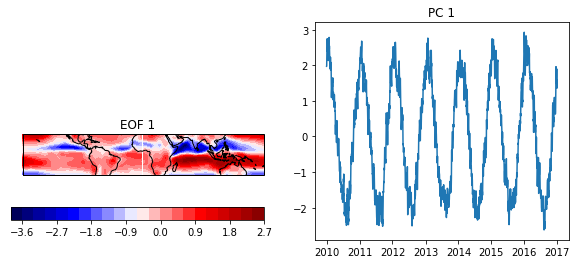

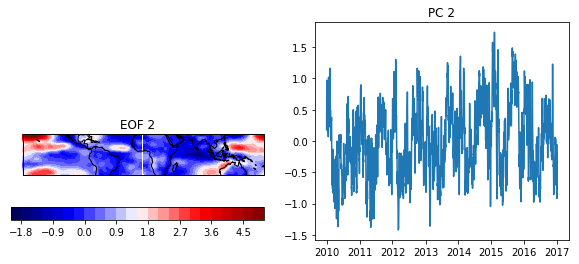

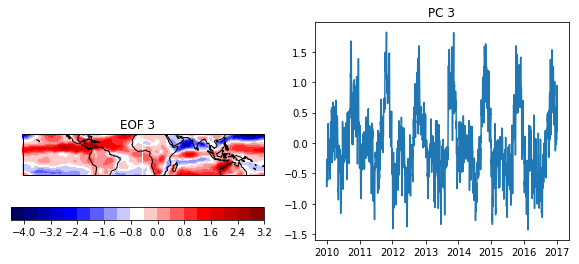

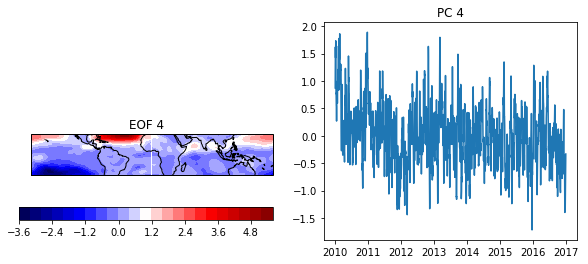

In [190]:
# Put all the magnitude info into the PC for clarity of plotting
for MODE in [0,1,2,3]:
    xystd = np.std(eofs[MODE,:,:].ravel())
    print(xystd)
    plot_map_ts(eofs[MODE,:,:]/xystd, pcs[:,MODE]*xystd,
                                 udata1016.lon,
                                 udata1016.lat,
                                 udata1016.time, 
            'EOF '+str(MODE+1), 'PC '+str(MODE+1))

## Check orthogonality

In [65]:
np.corrcoef(eofs[0,:,:].ravel(), eofs[1,:,:].ravel())

array([[ 1.        , -0.01909318],
       [-0.01909318,  1.        ]])

In [66]:
np.corrcoef(pcs[:,0], pcs[:,1])

array([[ 1.0000000e+00, -2.8812154e-16],
       [-2.8812154e-16,  1.0000000e+00]])

## Truncated reconstructions: animated
Grab some cells from Unidata's workshop notebook on making animations.
You have to make one image, then animate the others

In [67]:
import matplotlib.animation as manimation
plt.rcParams['animation.html'] = 'jshtml'

In [68]:
def recon(TRUNC, time): 
    data = eofs[0,:,:] * pcs[time,0] # Always include the first one
    for i in range(1,TRUNC):
        data += eofs[i,:,:] * pcs[time,i]
    return(data)

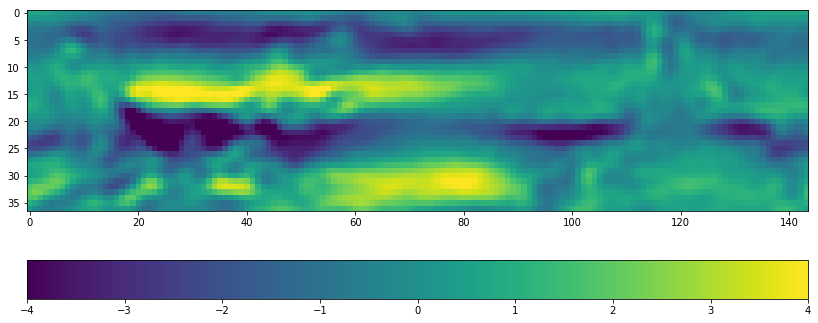

In [69]:
# Make one figure to set the pattern

fig, ax = plt.subplots(figsize=(14,6))

im = ax.imshow(recon(1,0), animated=True, vmin=-4, vmax=4)
plt.colorbar(im, orientation='horizontal')

## Part II: EOF analysis of Images

In [98]:
from PIL import Image
import urllib
from io import BytesIO
#urllib.request.urlopen("https://people.sc.fsu.edu/~jburkardt/m_src/svd_fingerprint/fingerprint_01.png") as url:
#    img = url.read()
img=Image.open(BytesIO(urllib.request.urlopen("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdHx8kKDQsJCYxJx8fLT0tMTU3Ojo6Iys/RD84QzQ5OjcBCgoKDQwNGg8PGjclHyU3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3Nzc3N//AABEIARABEAMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAGAAIDBAUBB//EAEoQAAEDAgQEAwQGCAUDAgUFAAECAxEABAUSITEGEyJBMlFhI3GBkRQVQqGxwQckM1Ji0eHwFnKCssIlQ6IXkjQ1U3PxRFRjk6P/xAAZAQADAQEBAAAAAAAAAAAAAAAAAQIDBAX/xAAtEQACAgEEAgEDBAEFAQAAAAAAAQIREgMTIVExYUEEIlIUMoGh8GJxkeHxI//aAAwDAQACEQMRAD8A9xpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpUqVACpVVusSsbNeS6u2GVRMLWAarO8QYS14sQY3jpVMfKk5JfI8W/g06VZ/15hYib9gTt10jjmEhWU4jaz5c0UZLsMX0aFKqgxOwLZcF7blAMFXNECpmbhl9pLrLqFtq2UkyDRaCmS0qYXWxutI+NMVcspMFwfCixE1KohcMq2cT86kCgrYg+6nYHaVKlQAqVKlQAqVKlQAqVcmlIHcUAdpU3On95PzroIOxmgDtKlSoAVKlSoAVKlXJFAHaVczDzFN5iP30/OgB9Km5k/vD510EHYigDtKlXMw/eFAHaVN5iP3k/Oml5obuI/wDcKAPIry+fW+suLUpcwSSSTsN5qst+4JhIMhO0HTb7tTVx/inCQs8vnk58pLaSIGh8xpJ9/p3qsrjCyKm8rF0SVgEKQkgCRqOreuLZm/g7d2JCpdwFJBSvqPTKN5UR5a6VCp95GaZzJMKkbGSKtf4wskpcm1eIkdkwrqPiM6fCaX+McP6EFq5ghJOiegTsOrb5e6jZl0LdRj3GIvpbgBKiRsUadq2OGOOrlGGMsrwsOpQVytL2SRm00j1is7EuKsMdZGlwFHoKdhGm8K9N96ocOvNO2JeQVqzLUQkxmSkK339Np1q4wcfKJk1PiwuHHt+UoBwhlK15SFF4kAGe0byK4rjnFlJzt4OyG0JSpyVqVImDBG3xrGayKW84FZRmaAUsgSS4djGnwmo7lMspl1ZCW3SDzNoc7aa/dVk7fs3BxxizmdKMHZzE9ADqj9ojYDXbt5GqV7+kXFbe2U6MMaSEp7uK33nbaqbrBUHVtByApRU5m8R5ogmBrGtYWOc1NgSpKYyRpMk5EyDOsR+dNJCcOPIXMfpjK7UZcKulOZAdXQE7gbgExqP71ro/SxfvJU6zgMtJUEGb+OogxrkjtQBg1lntmXmWHE+zQVKbcKSlQPi202mQQR86vJsErvLZo2zhLgSvKVKKnepYzJE9UiJInTv3rSkZhX/6vXwQr/oyVEJQrMLwwAqBr0eZFRH9LeKuiGcHZSoDUKuVLzmYgQka+mu9CTdndCxdHLSr2FsErZJ9jCyOs/ZOhmSI+FcOHqU0j6VYpUtwvHmuvQgkK0y5YCiNdAVg+VOkAXK/SxiyX0sOYSm2UXkoUF3BzIk7FJSNY91elsXbr7KXC4rUTE++vAsTbQ2tpKUoSll5Lag25GQByYUCB1TJiBpOhiU+x2eN4S1bMpcxOzSS1mGZ9O0H1rOfopUb+bUncSabJgDQnp7fOsw4/hOn6+zKllASDKyYnw7/AHVEeI8HGSL1C0KydbSVLQJ2lSQQPiammPg1FLISdR/c1h4ljz2G4raMpTnbeSvMM0agpj86avizA1qeQm+CnGUkqSGlyQDGmmutDeMcSYWvG7FTL3OLeYKASQQCAe9VGLvlETfHAYI4icXB5AIPk77/AE9Kf/iJ0afRtQCT7QxoAfL1rFY4gZypUWVIRlBWpZMCQryHofurn1+lbR/U3EvqSTlWSkFPLBkGJO3lW60/RzZT7NtXEikKMsKmTEO9goAzp611XEbsA/RnchOWeZ3kjy91YL/EbaUOvC2UpvIshYWZJGQwRGm/rtUf+ISeXms1SpSi6gKMtgOACZT609tdCyn2ap4w5dzasht1H0heQwQRqJFbqbgrA8R95rzm6xhFy/h6V24QVPNkwsGAcsdhrrqKP7eCE/D8q59RYs6tK2uScOyRpvG58xTedJBCQQQk7+ZrjehT/p9+xpoOifUN/jWZrQi+ZMpEQrv5GKjculNpJjadj7/5V06JPnC/91VrskNKMa6/nQ2CRWwrFncQNwsrWG0uFCUFW0aH761EqJI10n8zQnwaTybmT/8AqXe38ZorSTB9/wCf9aVMHKK+BJVOU7+GaZm0GpOvmexpyvfppt6GmLHadp3HrTxZOa6POHeHLfrzXrgJAJPKG8CdJ1227etdVw5aZzL1yZWABKNNR4jGv5UUuZSTDqQY80Dsfn+Xaozy1KSkKMkyBz9xJOun3GtNyRGIMjh2yIaPMuk6IlMolW5kGNPjNQK4dtABFw+JSnXKnKNzqO59dBRUhaQhClXCsoKQpQe1Gm0xUZ5cBJcOcgQCoFO3cRBPrPwo3JBj7Aa+4btw0spunQY2KQrLoNyIn7ore4S4UuncIadZWyWlZ4C3DPiIjRNXL5TZQcj0zISXHJnTvI1+MelE/BaR/h60jY5jr5FZpSm2VBYmZ/hS+ISOdbo1QZSs+zhwqIR06b0x3hTElLcUi7YTKXQpWYy5mXMHp8vOaNRqPfHx1pp2Ppm/GpLyYFq4RuV5ObcNmFqITOiJWDpCQD8h8aysY4NcTYXOZ9s9CikhR8onaNh8PMxXpCxBPx/EVjY64G7B8rVplO/xobY0zuEYRh30C1C8PtFBAbcSSykwtI6VDTcedaX1ThxQ80cPsy3cKCnkFhJS6ZJlQjUzrrQnh3HeB21hatuOPF3lpSEpZJJVGiR74328yDpV1HH2ChxIUm5QjTmLLYIaMkQoAzuCJAIn3ihKRNo314bYL5CnLG1UphKEslTSTygDpk06fhS+g2jbrrzdqwl11Kg44lsBSxOyjEn40NK/SLgaWyVt3qSUNraSWRLwJgZdfuMU0/pDwdbQysX/ADSlZU0WAFIAOs6x9/lTpitEvGVrYt4JdF23bS020oHIiClJOYgRqBInTuBWK1f8KNp0wq+EoJW4224nLorokKBEwTlGh+dVOM+NsNu8GvWLZm6lxJQ24psJCpkEiTOkiffQpZh9xpkAKlTSlNo8QUIc1O3ka1hC/JMpB8Md4ZCkOp4fdz8+MqrNGVKuXM7kTl+NQf4n4ZU0gpwFLiVttA52WiogmABqQY8pFA6FctKbhK1Sm4TkUAkKTDXlPurqStTbZcVlhlgsyCCUhZ1Hz7Vptomw1PFmFAICeHhyWQo25CEQiFayI6BPlO1D2MYlY4rilg1h2HIt3SSQpGVJMoJUJjTtHnuRpWSpwc91Vy4FLlZKleEnOCYnb302wUf8R4cOclxAJSk5lQE5dE/CPvpNRh93Qnb4D61wq5U7zTbpRKUaodGm/g+ZnbcxvUjeDPBxlADJbUEqU2tZM+yUN4kbDQVu2mXKjYAERvt01MhoEt6bBIgSeyhWH6+HRO0wXusMvXrd511pnMsKGqySSWk6biBI/pT38IuTcPLWhkLSFKStDqxlIUhU7mO86D30RpaBCBoMwG892z3pi0ILalHYzHxQn+VH6+PQbLAy8wu4YfsVLSyEofb8CyYOcCZPnAr0a3HSjbt+VBnFaFlpsM+P6SjJ7+YPOta2s8UIT7VQCSMvtdfsz+e9S9VavKNYJx4CJJ8BnU5Y+RpoByj3Nzr61hJwm+K21G5I/ZlYDioUdZmuDCb9SAVPpBSGkoPMUdlH0opdlZPo21CAfc5/uqvej2ax7x+NZS8GvcqiLpBUpLwUQT3VP9zUV/g90UrHPbgZokee/b1oaXY03fgpcJsLV9LHOgC5ciJ/eooFuCNbgxEj36UEcI26rdVyl0kkXC+24mijQNqPcpjb+EVk/J3x020uf6L7lsjrH0j7KwRp6Ux1i365e0JOkjTSqyvGpJ8yP/EVCqFI331/8P6U7Htv8hzlurq63jKhsPLv8O1RqYOQALvD1SEZ4ziD1HTesV1OPEwb+1AKu2fuf8vbby99V3E47CXDibEpGUGVCeneck/lWmD7PPzXQQC39qkfSLnN/wDVCzp07RH31EGEhkEu3ESOkuKJOnn/AErCUxjalln64YyzJ6T+55ZYqJLWOBAdOM26VQBsqIy+eSfyowfYs4/4zVxO2lt0F+5WSIPUYX8xpFScN4ZduYTbrbckdiVQTCvxodvWMYbaUn64aCUA5QUkRMTPTp32o34GCkcM2IWsLVk1UBGY5jVRbh8kyjHUXIz6oxIrMuwlWQql0zosn46UxzA75bagXUiEuxmWY1VI/vSiiN/h8OqmqPSozGipM+tXvyM/08Adewa8Up5XPT1ZhClEkAgb/KsvFuHLhy3dSt5vKNE6qmJNGju6vjFZuLucu1dV5A/Dek9aZS0IA5w5wNhS8GtlPG4UXmkl1JUmFApGZPhkAmTIhWsAgaVrs8CYA26HE2zhWgpLZU4Tk1MQDodzqQT331oXw79IRs8NbZRhnNLLaWwTcBOZQMbR9wk/DWrbH6S1qWkPYSGhoFEvK0JKh2R6Dsd6mpGnCNo8CYEUIHLuClIbiX1K8Kp0Jkp/0xT18FYEFLWLd4FSXEki5cBIUdZOaVe4kjSh1P6TXw2pTuCFCSlotw+pWaVKGvRA2899K5d/pPShICMOTnlYAU8QDCwNymO/mfhTqQrRDxxwjg1ngd9dM2yw8lpRzZyNdew0+Qjzmg+0ZDbSS60FMpTlWn/uKkKy5dNN9ZPr6DW4p49fv7O6srjCm2WlqLalKdKiASobQNdz8DRPh2I8Khu3R9AWQYCnA2Tyew1mRPp5me9XFuK5QmkwHQ28nEW2UNIJJbUEnI22qWzukAD4/wBDTrdl1LSnGrZBKW0lSm1BWQhRgkA69/l5CjpvE+Fmg2pOBLS6pLRaaFsiXQdEkJmFd9TrvT0YpgLYdFrw0talIXz0ptESmFahUTGpOhirzfROIBXinua+5y1ArDmdJSr2YlJzdRPzO1Q4eC5xFh5Vmzc1YEjxAA6yN5r0Z7FrNroa4VfVbJWeWpu1SQF5QZAAyx6hRPpWVevsXeOYaynCDZu89a1ulrIkqKTm1KQT21InTbac9WbwfA1ELLUSlPz37SmpkRmATOuTSf4iKkatVpSZcbGpHi7+Xvp4tQMw5rMg9fV4eqdfhXlbcujQgbScyQQYTkkz/mFQrylgDKZKAr//ADOv3VcDCfZj6QwSojJKx1wo7edRFplCFZ7u2CWwEqUXBCfEI+/vRtT6AGeKXUMtNOFCsofbVoDr7QUQ22LMZUZWnjJjROp1T/OsXie3ZNuAp9hRDzWZsEEkladI91EFvh1lkBFs2fen3fyrp0VS5Cn8EQxpkA+weEZBqAN1Ea66U1WMpIRlt3AFASCQD4o011q8LC0kfqzO4gZB+9SNnahC4t2vCqegdlGt+BVIzzjKOatsWzuYcwakA+fnVO6xxK21EW5Ikj9oP4fv1rdVaWxMchrxq+wPKql5bMFtXsW5I/cH8NDaGlLsFuE720ug+46SlYdWMo1jU0V8yygiFqB00B8j/KhDhy1Kri+yIgc9egEUUIs1yIG57x5n+dc0tzLhG6zr939k30iyzJIQ4ZIMx5p99RfSrQCA0uQlOnvBHnTRZryIJSJAb8vM1wWSoA02AmdoJpVrCd/l/YBuX2NA5Ql+CcspY0MqmNqpqv8AGgjmEPhISUg/Ru+XziiV/EHc5DeEXpMkA8yPtadvv7ba1RcxRQSf+i3pSExqudco7Zdf81ejfo4qMdb2OFfI5dzOecptBPh91RqucaKQ4EXBAESLYH7PlFbRxB6FAYLdBzOd3xl8P72X7qarEbkIJ+pLsIB1SbjKqcu8ZdvhTT9AD94rG0tKSUXPTJILQJ18zGtGPBjeKL4ds1I50Rr1wRCoMCY7HSse+u7wpdDmEOmB1kXUj4aH4/GjL9HbinOFrcqQUELdBSTMdau9S9SvgNvInDOKgKE3HUdyvbr9DppTV22LBl1MvKhLuUl0DXNp3okn7/T1rivCrYmFaUt19D2F2waurbFjzVJL+qlD9sJ8I3+I2qhieG35acDinOkK15oI1PbaPWjFemaPM6z6VmYxItHcoPhMUnrMa0I9lLhfA8M+pbJT2GWanQhC1FTCSSsJAzajeBWyrBsKcSpK8Ns1JWoKWCwnUyT5V5phK+Kgw1btM3blutxXLKVupzJzJVGYEZdCSFSBBgGRlE7LvGJ5TyrTEShlCEqUpboKVDNIyBUuDYZsp3mdKmr+S7PQvqXCvZKOG2WZoICCLdPTB0jTSpE4bYNB0t2NsguJUHMrKRnBOoOmteaL/wAYm2UJxW3U+23kjmulZKtZknk6EaGO/lp16y4rWhxkHF3Cj6QpDRdWnlyRklwwF+ehJ1+Tx9jsLuKMNsUYPc5LK3RymVhGRlKcomYEDQSJrbs0pDaSBG3yrybH7LileFOrfaxBTakuLWXHv3ZiQVT7pSPSa9Yw+RbNydYBk/Coap+Rp2WR9nTZKe1dVsdCfF321rhgDYfd51xQGvbxflQBxySTAkk+fpQ1xIkKvsNGVgj6Qf2+qYyK1omWNY9dB8KEeLigXmFBZISbnslJJ6VdlAik02Fpcs3fo5bSYYwpvQpJUNhB6Nh8/up6mEpKkhnCUFoKOUjVrUGTp8dh21rPQhnIlYUoaEEptmU9lHeDA9KldU0kOghwpTmIHIaASYB0ESD601CRO7DsmyN6EKwXK6TqEftiFiBvp3/e1pJyIUpXOwdPKI6ggDk9REeL4fZ1qJakZnlFdxKkrB6WvMd8vV7jTQ6yCkcy66VKjwD7af4eka9oo25dBuw7MbiZGfD+Uh7DULlsJSyAlQlSTpr3327d96v2+HYkWRN4derRwjXT0rN4gcSLEpQp49aPEpA7pOwT6fHftRVZ/wDw6Sf3aKcfI04z8GccMxFQOe7EEmetW2efLyri8GulNuJXd6ZHQmVKMSqfSK21Df3K+GtcWNFztkX+IoyYYIxl4NcF1Si+kL5xMyrbJETVN7Al8pIVcaQk9MjWBtr6UTq8Zkfb/wCNU7n9n/pH4UOToagrBfg61Nqq9az5wh9WvyotQCI+Hx1oQ4fXdm9xAMJaKQ9GY7zAoi/6mRoGUk+85dRrUZlbXsumQkeYj7jTVaDcd9/81U1oxPKoJdZEBZmN4Vp2rjjOJHPNygTIIA2Gh00oz9BtLsa+80lwys5pnbYzv8P/AMVV+kM5QMx1Hnucu/8ASpbgkPeNW4iCvUk6D41UW4EtZ1PqQNi5nUkDp8M/lRihZMm+kt8xZDiguSMwRodNoifuqMXSCnOh0hvNAWW1FU5flUS4zFDk7n2QQ5I6d8v51yY68q1KOhUEOEeHzp4oWTG4hcQysKzIKBKhylENDz2qnwqvFE4QPo6HQjmOKAQiQOpXn69qkughLUBDiQDKfZLGsD1rX4EI/wAOs5dkuOgf/wBiquDUXZM05qvBIq4xjcBYCwrQs7dWnbyNNeXjJ5jaEOkgrg5QNwD5efr8KItBOh0n4a1xeytfPX4Ve6ukZ7T/ACYNPKxhQW4nniTABQP3PL3zrFUsRYxflOyp7pByguJM7bnvRc54T5f0rKxp4s27q09gdPlQ9XjwhrR9sscLNrawOwbdPWlhAOs6wK1knYe7SvMMI49vUWjNuixZUpJDaFSokhJEnKInQ9iNp12q3/6g4qOUr6iKP2YW0rNKioHUKgZfOMqpjcTNTizS0ehEwiddh221rhVor0Cp+decH9IOJG0edRY208sKEhUNnMR1dXV7+n79Kp/SNigZIVb2SltB7nuNpUpKQkiPtab+vbzowYWg74oTnwa+SO7K/wADVyyOa0aUO6QZryzGuPsSu7O8DDFsGFIUEKWjLA0Gsr0mT+VG2B8RYUcIs1O37KVKZTIJ20Ek+QnSdu00nBpjyVBGdUqgdlfjXTqowQDJE/CsxziDCEpWTftBIQtQXByqg65VbK+BNRnifBwSTeR7XJlUysGcmbYjy1oxfQWaqiMoOgGh+6gnje6btr7ClvDQXEjKoCDlMa9h61sr4vwVKmkqvCC4lKkksrGhE7RP3UJY/jOE45jGEsW7q3fbZoCSmRlPcj+5pr7eX4JlyqNlWOWQypFtdqWrw51pTulW8SRptoe21dXj2F51JLFyGypQSvmJzElvyiY03mrjWC4eeVKHiAR050wskRr09p7RTkYJYAJDaHgoqCs/OTIORQ2yxG/bvVfqdDtmG1Izl8RWOV1xuzddV1yEXHbIkyJSJ93oajc4ktg+4hNi4rKpWUrugSoyg6gDTftWycNsFAq5CzmBkF09249+3w9Ka9hGHKCkm10ClGAuOyTsBA+EGmvqtD2G1IE8expl5gobsvEoAOB4mD/7QNPf869AsTNqiNsun30K8R2FmLF9SbeSFFclxW8kTv8AjrRVZAC2R6J8/fWUtWGp+0304uK5Lihorc6K/EU1Wy9Oy/ypKjq9yo+YpLMJWSOy/wAqRodUOsxvn/41TuY5e2mUb+6riv2h1+2P9tVH9W9ROg/Ck/ALyCPDt283iWJtt2y1xcaEbeEUS/TbkJJ+hL8Om51gUM8O37LGKYqhaV5hcTATP2E0UfWbOQ+zd8BPg/hms/k1/gjdu72FpRZnMA5qdj3FcVcX6sxFqAMxAED933ipHcVZCVENuHqUNh+7PnUa8XaV4WnMvnKR9mj+RfwYV/jmHpu3km6UCFlJTkXB1Ejb+nurNTjthoE3cLCOk5XYjKNPCTP3VcxDhBxd08tFwgZ35gpP7x9f7203OUeCrlDZ/WmpzQSQQB09z2PpB99dV6fZy7ciZeO4YEaXDuUrPSkKK5y+ukfGfSoncew2SguvwDJ6Onw+us/CnDgtYcBXclKJnVgFQOWPDm29ZqNHBiktnNdHmSOkW8gjL/mijLT7DbZUvOIMPUwrruJOhltO2nbNpTuEuJby1wlKLd5HJ5rikpW1qOpWnx33mliPB7aG3CL5WUp6CWR1HTvm9NtKzMDtuRh6225UUuLidiAVa0m4NcFwg0+Q2d4sxAOOpD1qJS5lCmyMkKAkSdTrsaT/ABJixQ42l5pBTzDzCzuABsNe/wCBrGuc2XOlwZShzlok5knmCZnck11Slu8xMpbcl3MFOGNR5D+dTRrSNZ7iLE05lrdlUlPIbYBIHLBzd9KGuIMcxNTLjaMRU4EDNmARBnLuQPXaplLU9b8xS1KOfVS05teT5msTH2/ZFYlJAgtxBGie1NITKmCOoLCOY6G1HKVqW0mEjcTJ1nUdu8baWLdhDbbIYBFwrlkM8wBxfSZUBJ9ex27VUwVATb27htc5ASpBLWbMRvsdQPj8IqVLjC1sIZDjjRSyXVrAWtKgDoCdB7q1MBiEzbksIUfZy9kdVAhUEuToB6giPhAnexFH0Z21LXQ0i5AYJhLGZYhSdwN+9Vy3bOsErbZaS2yOX0mVgnQ66J0mTtptUdyhJXcqStamUc1bLbREpMTJOvTPkZ21pgQ4sk21itHsHYLiXVoekOHNIyzvEiSn4xrR9gGOcMs4JaG5wdWZTASsi3QQekyqSfMETvsKAcSSHG3XTbPFaisqdCx3jsNANY1JmauYAXfqfNlcycrRYiAcqxG06+WxinjYro9HdxvhUulgYNmyJdVJaakxEySrXfvXRxfhBWLlrB255gSH4QlIlB0zFMgx6R60GlKn2yi4aWkkvFTS+lSNEwogR+A3qEtKcumsz7DyM6B1OAtiWzukwJ7bzNG2gyYY/wCL8LbQ2hGBJS26hta20pSFHNpIRlhXqZ7VkYhxLaYljeFsuWn0NaXZUucwjIYGwM6jtp670O2bVyOUtK0qKUtBtS15gnU6fw+7+wrW3T/iDCW7lZU2XICQqSOnXbbX0pT040GTPX2rrDghBXfRGWJQddojTfb51Mi6w7M1lvScwTlIQY8JidPxqK2ssMypXkdBCs09c5pB+eg9as/QMNggoeIlMyV6amJ+feuHZXQ8mQN3mFlKFfTF5cqYOUiZSY1jbemfTcLKV/rLpkGSEHUZJ2idhvVlqwwpJbUm1WSEoyjKvq0IHv7002OGFoIFo/lMKJCXBHQRB1nYRFPZ9Bk+0D/El3hYw18IXcEmQn2ass5jpJEefwFE1nH0ZEayn+dYHFbVqnCbtTVivmBBIK0mEmfU7d9PxrRs3sQ+ipi2a8M+PfQ6e+nHTxLUjXPfbv8AiKavZesdK/xFVC7iJn9WZ1zAe08PUN/P4UxxzEilQDNsCEu6lZg6iPdV0VZoKPWf/uf8aqP/ALPXugfhTVOYjzpDdtBcPTnVI6KqPfWWQCbXwg7GNhpvQ0FmJwu0j6yxRSkCTc7kfwporUy1kILaIMz0jeDQrwrmF5iPPW2pznmcp/hFFYUnQZgZ2g770cGbbs6UoKlLAEkwT/p86YYCR20H4U4OJyglYIkSqfSog62QgcxIJSk7+hp2ieQcxq8uWsQukh9QSHVgbeZrK+sb1K2yHiSkQJSIiDvpqdKtY0oKvbkzrzFn8Y/GstQGbKderbXWSrWuZvk7UuCVOIXeQD6U6OrxAwfBtprFROX12pEm5e2GgXEdFRoiUEbkiCf/ALdRGOXIiNNY/goCiPEby6Lav1p46mPaHyFN4XwsXuDFxV0tBK3BlKZgjPHfbXauXiRkUIiCfwFbf6P7HnYCpRSlQLzsT71VrGSS5MdWEpftJ7jAX1hXLukpJDoWAwnROdO3l8K6cFWXVNqugEBS4UlkBZlI3VMka7TRM5YhXMVy0ypLn2t5IpxsQVKHLQU5le7wjtV7kezHa1ARcwEIUpRfIuCRHsAERyyD0T6VnYzgbCWncl0+ptQhKYiFQjXtNH/0I9JyJ0Ke/wDCRWdeYaeVEJIgTofIf3NLdihrR1GeYYI06lm2PIKnm1JRbpKGwtwQQopJSR0jz3kd4IVvauONIUhSSwpTWe5YYyIbOxSsoA6vfqZE717Rwukt4JZInwtJGm2mlaoJ01Pb31qtSx41weDlLts1b2zbF22tKEJbz2yyq56hHJ6TGneftDWpHGsTeF0WrC+D60u81v6Otbo0+2CNpI6pGkSO1e4zKRruBp5006giDACvhRmGJ4Niljib7bhatcYcbcUpLZW2Qk+EmSInY7pGwqLhwKRYMg+zUgKCyWwCkZVDq7nePT0r3DFUpNu7nMCDJoEwJ3hFTHKvEAXLbzmdKisAqzxrBjYDfT4zVR1PQnEHytYdeWt0MkuLSjJ7R1JLafjBg7E+6owklbbqGGmkKS0sNNvEKWCkgdW241BPw1o2t7zg9gNNIQ9lU4DzCp0qzZNtTmiB26aYziXCaA2m3whS8yWS0y3bJUHZ0SrKDB07nX7q0z9CoCUNJbaY5aG3QUN8wB4nIQsxMHzMSNKrNEp4gwuJkuQkTJ0QoflXoIxXAEiG+G3Skqh8fQUezIXHUO2pmsXHr61dvsPTa4Q/ZrVcIKnTbhseA5df8sfhRlfFEtcB7b84NSSsaeZ9atKL2eAV6KB76DP/AFrGbedFuQh94EJM9uytKsu3C8zgDjshKz7tQQYp4MytF8JezJjNBI017LpqWnlESCYCRsf4qqKcXPUpZ6tY3V7Qb/OmAGd3dcoB16etX86MBWjM4ubc+pbkqJSnJqdB2q7YNJNm2RiawCkQStPi/vtWBxRbuDBHSWlqAbB0B/dTW7ZP2fIQXLe4K+WJKkqmNdZrLUVGumXeSAVzii9+vqT+/wBv3ajWwgtq/wCqqy5XcvtBA6+57xXObY//ALZ7RQCdD1dfv1+NcU/aJQ5ktLmSh0rTlVp1D1/CszUeWAFKJxVzPzCc2cR4No++qlxbsHpOIPeEQnPJBhPV/X1q2q5tiV/qtzkzqheU69O1VX3mSlQOGPkjcFvbw6ih2HBk8K4ewp7ECHHD7c6zHYUVDDmQQczm4PiGmp/nQvwpb3TjuILbUbcG4Psz20FE4s7yR+taA6ST51yyjb/aWJGHsQnVWyPtb1z6vtwgdKzIH2z510WV1oPpaiIRMH1170w4e8UgKu1dO2u2vvoUP9ArBPFwU310kyClxQ/8jWbBzSrSDv5b1scRZTi19lE+1Uf/ACNY5ACgNBr3/wBW9D8nQvBFBGUaEhUFP+io1D2YkBXqNvBUqPCiUnxdvF4KiWBy4g9tBt4N6AKt6RkUZ8/jT+EOIb7DcPeYZLakB9akpWgqOyiYj865eAqQvqJ32P4VLwbgVziGH3Kmbi3SjnuAhZVKNAJ085+6tI+DXRwU/v8AASq4uxFK3M7do2gNuZQttU5hljZRjeup4rxZbpQGmP2pTKGVhX7OQINI8J4ioOLWq3UtQUCkLOkpHu/E+6pmuF79taCp22DYdzLKVkfYjRQSD8KZ1t/S18FJPGl8pdulKbbrCCdCE6gzIknt5/1zcR4mxN21k3akIkGU2yZJyzlE6R95rbZ4VvEttpceYAQlsBCVhKVkZpJGQg7jU+VVLvhVSbfK9iLaobAUCsnLodIkCB8t9KLFf0y8JE/CeBP4lgNm8cbxFlt0ZnWm3IkSDCT9nUK27GPWtlrhi9QUOf4ixDmICENkqOXKAZlObUmTrp20rF4Xxu6wvDmbBGDXt0lCi23cMp9ms5z5agROsHatf/GTiUIe/wAPYwWQQlwhjqQrLMBPfXTca1qrPJnWTo5/hF0oQDxBihTy20uAu6LhUk6+eo1nfWa4vgphYWh7FMTcbKXeWhTqfZFSplOmhHmIrqOKcQWhsjhq/CnW21ISoKHiJ0UcnSRpO8T3piuI8dKXEI4VuC62FlXtoQRm7KKRJjXQGnySRXnBGGuI9vc4g+ZXzVvXEl8HYLMagdtqt8GWVvaYUm2abGS3fcCM0EjqJBnzg1TvcX4muFLRaYAlpCwrlPXDuiYI1UnQmdd8vxqbgZy7VY3isQbQ1cG6WVIQZCZAIE/jUu/kr4CRDLQCEcpEZgYCQATrrXQMqUgfuo08tdqf6jz/ADNN7AT2j3waBDVZj32n8aEeLHuTeYSTBP0oaHv0KouV3EbHb40C8cOIRf4PnXkH0rUnX7CqqKtkz4QVNYjDYBSjVJO3ofWpFYp0qUlMnKrwiTAANYzVxhikoAvGpXIk7THc7Df+VOVc4em167tJkKjpIMZBrHlpvW6gujkc5ms7ii0lcJ6QFEEDSQRXHMUKSkScxUQdB2cA/Osy4vcOm5UbpBgLJlByxlTsahuMRwmc67wgSvXKZjOnfTTtT210Gc+ytxZiLisEuiQqOWRPy++iWwVNq2YjpFAXFOKYc7hF2m3LjispAIRCTqRm90ijrCzmsmSd8grHUjR0aLb8l7+Y/wB1MV4T30XH/up4/Mf7qaodKo/dXPzrI3GujVfn1dvSqt4SELMecf38Ktu/bg6Eq391U7wEoXEd/wA/50n4BGFw4LwvXqmXUhBuFQFD+lECU4j/APVRuI0GuvuoZ4XunkO3qfo5WgXCuoTtp6e6iT6W+I/VjuM2h8x6VztxvywZ0IxGB+sIEhPbbX3UxTN8cs3WxMR/mrpvLiD+qnXw6H96mquLztakEFU9J86Vx7f9iB3G14Wu/uwvE0tuF1wKSpEAHUnX+/nWeUYY44OVjNt1apCiEg+LeT0/GtTGMEw169uVqt2c6nVkkPKSZMk/ajWT/e2Wrh3C1LOVopIMdNzJTqrwTv8AGa69vT7J3ZL4I0s4YlOb64t8oV2IzeCPDMketRhGFBaWji7ckAjKmU+GPEDHwmanb4Zw4FEM6yOlVz0E5O8EGfj5VH/h/DOWAm3aKTBK13B06dtFAUbWn2G9Loo3r2BhEjE1rzbZWVCNB/DUPBd+EIvE2r6ksC4MZkydQn4d60rnBsMSlak21ugKEQStROg7SY+6aZwZw+i7VfFt5LKm7vL0taRCToNO8dqUoRS4NNPUd8m8jEblQMZJVPSE7eyB1JNObxJ/NIWypXMTAG4lHlVhHCbvLbi5aMESCggK6I37e6pE8LOFaCq7TywG8yQ2RJHx93cVnj6N9yJk/WF1ymjzGhAakEDXrIqlfXj6mVe21VrCY81f0oiHCpSlSReETly+zzbLnuarvcKt5QHbtSwZKwltImc23lv60Y+hbqJf0e3KHMHKOcha0vugwrsFz/yHzFFyex7f0oCwLgjBX7VwPsulfP6nEPKTnAJ0IBiCCR7u9ah4DwuQ4zdYky+lIQ081dELZbAMISY8Op3k+taqqOeXkJ/sAkFOiSZ7a1E6+y3l5jraCvMEZlAZte1DquBMIWhtBXdhsIaS6gOiHsqpBWYkme4IpqOAuH0BaRbPlshY5f0lwJTKtdiCf9RNPgk1b3FMOZ+kIdv7VC2TDqVOpBQTsCJ0mszhC6t7s4mq1ebeQm8UkltQUAQlOk05zhHAWlJUMOQrllRCVrUpBJJOqSYMGYkaTpWdwndYVhVziGHpetbQJuAG21uBEjIPM67H5VNK+CvgMx7zvOvvppEjQxorX41V+tMP5fMF9alJkBXOTE6etMexjDGXHEPYlZNqCikhVwkRoD3Ohp0xFt0D3AE/GvN/0lj9ZwnNmI+kx0+40ZL4lwdQJTfoWdDlSlRVBEg5QJjTfagvjTGMMvL3DmW3kuON3gCpbVCI0nUa/wBKuFp2RLlEjTIUpK0II6hCVnuCjpgn7418qrtWjqWEQl9PMjMWWoWDyiI1VqNN/uots28PhOVVnqhIII3QFJgGR4Rp6VMwxY8y3UhbBUlASkobJXlyqEJ0kp92ldK1o9mD05dAe+0jkuF3OMylEMpQoKEsg5pVJI0rt2QXH1NqzCVnMAmPCgyJVv7qL27SwQyUNhgNE5ihtlRQTy4mQneO1SOpblww+ZBJ/VHAT0J1iKe/DsW3Lo8z4mtx9WX6kIVmIWoEpBz9ahmEbDt769RwU/8ATmNf+2nX4UM8bOITgeI6PZuW4BnQlAJlR+0Z+ET3iKJcC1wxg9uWP9tc+rqKfg6NODj5NM7xI3/5Vxc5FafYX+NdPfX+5prngX/lc/GsTUTg6lz+8f8AbVW6EpP8vdVtYOdW/i8/4aq3Hg210P4Un4BGHwu8edfJ7C5P4CiYOKAH99xQtwvJev52+knf3CiXtPofypJg4skU4rq9xP31G46qD8daSgQFbCErOg9ZrjgPVrGp7elVZOLMnElq+kOkKSDzFQSpOmh8xVRKgl3SAmewQojqVoPOp8UxNxq4fC8NuVhLigVJQlYIExGs7/jOg1qn9boK8ysOu9NFOfRSYMq3ga/Cd6dMnjsehMhBKUKGnSeXB6e/kfnUaYUkE5FqAHUpTcRB02IqJvFm0KQlOFXqVGIQq3VmPTMgxAHxpn1wcieXhF3y4EoDIRKsp1hUHy7R60c9BS7O3DraUrCXFAR4s6pO3kO3rVbgrE7a0vsUaung2pT6ViQr90D8tvSu3WKYiQuMOBXqVKW+gCPSFn+/lQzgDrlzi+IB5KM4cazZVFQHqZGvy/lSaZpBJuj1pnFcPWUJTdsSqCJVHYn4bU363w4JBN60IDe5gmdoG5oJZzti2CQBKk9O6V+zOpHnr6U+XQ22pTIKeTb9YSZT1H7UmKm2a7IYKxnDEpSfpjcKHaVfajXy371nX/EGHIZdyPlZROiUnXUjfahpQWlvpSJlzfc+2Hz+EVRxIOrTCkZypSsqcvfP8+/nRdhtUPwnje/aurtq0tWnWEvqjMhUgdIKhB1AnwwCcw1FbTPH9yo25OGNe0KU5fpESSlWsx06jaCdY3ry/DNbm6afDiAp1JzhBVlIOkjbv79Nqt26kOJt8xMoLRYztKBWk5gZAOY9uoamB7x0KKo5m3YdsfpGvHkAnDrdvoZKyp2S3mWRondcR/D99Vnv0kXrvNbt7a3aLSnUlx1CocKSISBmGU666mgxKEBDI+kqKRbshCXspCFZ46QrWNSYHnqa7d3Nq2XrfIzcKH0npUpKQ3qOpCdIXvGvanihWwmxHjvHX55DLDCXVZWsrSlLUcyZyE6E69xEetZ3BeNYVd3l85xFK7hb6VN3DcjL0jYpM7j79NzWE+HeY9CnHG7hcc24JC1pCkRMlQAHxP3iqHDLxt7x/O3nkBUHUgidff76aihNnrisQ4LSFvFolTrZQoKStOmQH7RCQYA210pzd/wezlbYs1KZ537UNKPWW51k5zI9IoJQ59Id9i2OoABmAUrGRwZjuQrTtpTmrh43Cbhx43KiWlcwjWCkpyyDPnv3PzrD2LILXOIeH0JDrGAKLiW0JQVMNIlKgQJMyNvKhvirHrK8RZW1nhqbZAuW4kAHKCTGRPvOk9571nc9bKnCq2JykALUP2UKI1AjTtrWXfrUq6tFKRmb5rWio6tBuRJ70OCSDI9gw4qDCParSNCSUXI7+/8A8u3lVxCArZ4KSpQkcu4VOp2Gbr33qhhjzSrVr9QcSYB9nckR6jUa+Xu3q6bhsaDDlFKljxXJg9e7g7nX+KuBzj2bibbKktkkqywCfo9wo+A980j3bfOmP2qS0MzEaER9BA1KBr1HKPd4qkaU1CCMNGZIQCVXJJE5hAMEx8t9qhWsJCOVhNk2pSB9uQJQdICB5RRuQ7EYXGISzgeJaIaUGFpJHKZH2tIEq/0n3zIFbHDuL2jmEW6lOgHliUkHyrH4vcdVgN8lDFmwg26wOW3JSNSUzpI77D3VpcN4ZaO4RaqyqGZqT1+YFVCUZLgTb+AgF8wvMEKKoB8KSe4rj140lKpzeFweE6fGqq8Ds1JMl0aKmFDXUenpXHMCs5WTnKYc6SdBMVpwK5FleIW6XshWQc+2U/ueVUH8YtgyCMx8Omg8vXarH1LZhRJ5k59838HuqC4wqyQ0fZTCQBKjpoPWh0CyMThPFrFxd2VqWhX0hUgie/p7qKPrKwDUl5UQZ6Tpt6UNcHu2CW7ppSUSLpwQW+xUdNqJ+fhwBWrkgFOqijXYabVma/72cVidgFrBeOmbWDB29PWoTi9jllIdJP2QNfDNWDc4YlZR7KQo6Jb7x7qhOKWCQHEkFWg0RBMpncin/Iv4YN8TWiGsUuiMZubYqfWci0LKRM/CPKsXluJcTl4nakEltKxpHV4sx0P+bWvQcZKBePILbZJWdZAJ09ayyWVq9rbqymM4bjfXbXb3Vq5u/wDwxxQHNtkQj/FDZaKgSUzmJybATm+WlRlkcsFziJ0xACmkLKR0nQlOk/ftRgS0VhSWpegAKKk5dtjrANRB1pOXlMMuSPEtxPkdO9Gb/wAoMUB13YWSgqXsYeyyUpLKhy5iZmN/SouAb7D8MxTE2rph9ALqVNJBBV7t96MXngWVKaKEjcrJJzDTsEyIoKsMPu38dxJxFo+8EutghtJkHt0z5Tv86mUnJcnT9LCEtRJsPWsb4ellAecBVCwS1oJSdDpv7qTeN8OlCXCt4EJbgFgyrUwRpQq1ZXbSm3VW12haFN6/R5CT1AlROgPvB37Vy3srxthCVsXBUtLByKZhSusyUjuKypHqv6XS/J/8/wDQVrxjBUIzNIunc2fOEMiW+sTmmO9UMRx3Dg24GrK8d5cmSAEnrA3nzrEXYYgrIpuxfUU8wqhpUiXAddenaq19gOJPFJThzyStasii3qOsbq0jvqaaiiH9PpJef7MDDbj6RiFw+whTbBuW5GkETqCTtO+v7unenscxtpoNrUHXCzlaCJJTK4ywe3w/msNwe+tbu5U7aPFSnEoKBMOiQeXmAjWJ1kdI0Paa1becUw0hy6hHLTzFPgFiM/s0jeOxIHfUDauqL4PGmqkyu4h5TFtkdfWWW2ekNyEnmEZVGRtG9dQi9uDehxpasrN2rK0uMnUCTEEBOvvNOLdw6gBV04z0MhLfMLn0iXSYJBITHkQNfKpncMurpDqXCu4KDcrRa8yTbqzAhWkg/wDiBrTIKpStSVqDTaVMrKzlJUhHW2Mx3KtjvPuFY2BAoxF8pQrMlGxIT7xp2O0eu4okHD2Iu3CXjZ3N0lTuZOTwu6okFYBGXfYiIIPrPwlaYZhmK3Y4nZWy6pscknMBBBCpg/j9+lNSSE0caSGrpp7kA8xQPUQkQQ4NFiMoj1j1qF5XIaaS64lRLNvkSk9B6z4h3MUd273Bzd0kovXkrbXkSkF0EmVjpgSN1eGB5imW7/BduwkNXLrgcQzGQu5kiTl0SASdTvJp5+goCUnm8lPQpZWpLaCOhMujSdoPvqjiNuWzZqyapcZCiiMuYZZHv/lXoSsS4RzMfqDzsqUllRk885wCCCqTrHjArJ4hxCxcw1X1bw880UugKcWwEcsZklWonTQaA9uwiVKTaqgoLsNV+qo6EiAPhoTWjoMoCUyFg6H+P+tZeHvexQkpidDJnTQfnVwvnlyQJEq0nySfnXmv6TV6HuxJ82UxAkqTGm/X/Wo1GMoMCAkbf5hXHHTKjlVl6iPgsUxTsKywkDPEEb+0NNfR63QbsTC4uE4JeiZlhX+2u8NHEm8Ls0pDiklobgbQO/8Ac1HxM8r6muVCT7EzpE9Iq9wtitunBrTMVyloDRO+lbQ0Z6S+4FNSL5u8RyqkPDpUJ5G2idh5++k7c4kC6lKXFEIcMKYjsmPSry8TtU50lwiErg5DBgCuuYrZpK8zvUM0pgyNB/StL9FV7M15/FVZ1JbcjOQIaA+x5Gqd43iykuJ9vEaQ4keXfvW0rFrLmAcwqBWBIQYEoqhfYxbobEtu9QSfCBIMa70O+gVdmZwY1aJt32rrkKdTcuJJMT4j+VFAYwyMxRb+GN9Ij+XehTgxuyv27p1TYSs3K5GbXfSir6rssmgOXYjmGJiKzp34NLXbHcvDEqCCLfxzqQdcvn7qYH8NQErSGRATBSgTsfKnjCbFCgkoObNIlZnwxUQssMaAIS10pSNVmPjrRz6DjtjscOW+d6kwVaguZRtPlWNkHMTBQFbBWZBy6HQiNfupcXfXLWKXRtm237da+lKgkx0j3Hf+uk0MKuseS4ZwpCggpkBhR5hlQkQrq94gVs4q/Jj93QRpK05T0/ZBRmRr0+4n5VFzAQEuLAUpKSEpclJHmcqd6HEXnEHsowpCFZUEL5BSEiDoSTA+OtJo8TqRnbtGkISEhSYbTmVB16jPftpRgu0H3dG6+8lWpeCyDIkrIGg13FU+BLxKcUxhCSY56NSkJnp8hWY/YcT8kBx9FuNOo5U5jA6ehMn3bfGsvg26aw/E8TTeXOdfPRLolWYwNANz3qXGLXkblKPLR6+m9Mt9/Dr8643elaEnzS2d/MxQvb4zhyl2wXetpWoNkZjljx7zt+VdYxOxDLak3iJCLfNK9dVEjTc/Co212LffQTKvSUjTUZu40hYqpd3h18wo/wC4D86wji9iAkm4SvNzPBJye0Gqo8PvMd6pX2M4clahzC8sLVo0lSgrrTAkaH50bSBa7+Am4Od5qL4hSTF1BI/yIohKErgLSFCQYIkTrXlPC3HNrhz97bvWri87udBCglRVlQkJIPbRWs6Rt3ooY/SFhTlzbNfR7oc5KSVp5awgkK0OVR/d/nFUoNIvK+WF0aD0CY9KarSY8lT86DFfpKwnkvrRaXq+W0hwfswFAqIEdfu7d6a7+kNk2fPZwm5Mc3NzXkIR0mDCpMn0ge+niwtBg+N9O/5isDB2W1YziKFoSr2bZ6gDoc4oWxH9KKszqbXDmknIeWq4e0zdMaQAd9RmT7xU36OMevMdxzEnbppLaU27KUlCSElQKgqNT39aTg/I00HyMPskrbWLS3SpGiCG0ynfYxpTWsPsm21oas7dCHMqnAloALM99Nat/D5e+miABvoE6fGiwI0oQ2lKG0pSlM5UpEBOtDfHYjh68MgEIJk9qJlHUfHT41gcYaYHdnKFQ2TliZpksw8Pu3wwiFJASqd5jqTrtUyrp9tlXNUiS2e6eyUfw699K2cNeCrZpX0VRkSClYPkfhVta20I0s3SIOUCBHh+Xv8AfTwn+RzOgeevXAXClUgpe1TEaOD3edcXdOZkFOdYU6qAJ6vaneI+6iIuJSpRFmvMc09Y/eHprTXLopJVyUgA6qW9AHtDv8qrbn+QrQC48zcXWEPryuLJbV05DCegaye/w7UUYDg9p9Vsy3Etg6KI+zVHiPEm04Tco5tmhZajKFlahKRGmtb2A/8AyxjT/tp/21EouJtpUyVWFW3UQXASlYPXvMTSXhFpmWIXHX05zAMD8qvmerzhX4ik5rMTEq/ClbNsUZ4wm0zSUScyYMgRp6aVC5htklsRbogJT2ntWqfEJ80/hVa4HsxPkKTYJIGOFsLtXXL09SVC4UOhUfdRIMFtytJ5j0DcZhroRQ5w7hzL+IYmpTiwtNx9lWvhTREnBmgR+sPRpKcw13/nUVfwaXXydRgtsAnM48SMsEqE6CKb9UWKAkkHKhKQczmh33pIwZqAo3LxICYMjtXPqazTqtbpiCqVQND6DSnj6Fl/qMjit91vF7lTTi0EL3SqPs1g/T7oOQLhw9QEZtD1EfGtbigzit3PZ1fw0IrAWetUkDrHbb2hrKT+5mkVwh6L686f1t0ylv7fv/lTOfcKKVOPrUpKUAEqJKdTp6VCIChMfYCRHi61elcEE7SRlHlHWaB0V3kw0ADMga/AVicMqyYpehc6uo27bbjyrddBU2Dv0jf3Vm8N27hxC7KWlkLfQ2ClEidDA9dO+kTWmn8kSRsWaOUu3abSkFYa6FJ0V4tfKmtJQG2VLCUwi1leXKUHOdtff91TsNKZbzuKhsLaQtCinNpMeo3FMYRkTbpBSFKRbQVSPtnfTWtRUjqG7dDWYJGUtuhK9BzhzQNd/PvUN4WgFISMqBnBHMkBOdOgOo8+w+NOKQptWUIC2kO85QBM+0Gu2hrrlupYaRb2zqg6tYSsIUSfaDUawaYUjU/R1g2GX9pfG8tGblSLwKSpxGohtJAB7jU+hnaipHBPDwLhTYRzVhxR5y9wTAGug9BpXnPDuJY7gN0+hi25du6tAPNtYBWYEkjZUJ0nQ6nsK2Lb9ImKm9Sh1i05aIStkNLDy1SqYE9oE6d9u1FMyfkLVcF8PLDWfDgrIhCQFPLIUAqQCJ1HoakRwjw81my4TbZSFgIWnMhIO8JMgfAUFK/SNiiW1lTNkC70sJCDmBCohXXodRuN+xrr3G3ETyza2rVoq4SpecNIlaBlnuYUNRsO4FOpCtB61g2GWbSW7awtm0IWXEANDpVoSoHz9azbFIHE1zAAlj/lQfd43xjetuOWhcIVKAbO2DjWrY2VBjXfqkHyqTgi4vLDibFTxJcKt3XG0paTc3AV0hSiYVOsTv7z2qXFjTPThIO/cSY9a4dBPoPxqsMRsVKeAvLYlkp5ntU9EnTNrpPrXHcTw9lLSnb+1Ql0S2VOpAXqPDJ17bUhlhYkHWTBrA40b5nD2IIgmWV6fOtF/GcMZW4l3ELVKkAlYLydNu0+tDnGXEmFIwO8Qi55rimlpShtBJJ1HlA186dMVonssIt/ogBYWEkdSBpmgd/7981NcYFbO7quPtZlZ4Lvh0Jj8KkwrEb04e2oNuKIQNuWRt/m/L5bVeViF7LsMrGVKonINsv8XrST1fzMmodFBeCWmdX6uuAF5U5iQiVg6f1mnpwdgKQPoqiErJTmzH/uT7vlV1y/vAlRCFQEuEElvUhWg3/lUT11iBICYGZRBlYGWF+gP3E0f/T51AqPRi4xg7acJey2TSSGyZUkSOkTqde1beCwcNY1/wC2P9tYOPrul4XcF55CiG5yCVA6e8fh3rfwSfq5gf8A8Y/21Pz+6zWFdGkZhW+yvxpK8SvOVDf0pEAzpprPzFccOqiP4j91MoQie2pT+FVrmOX8B+Bq1pmjbrA/8arPH2eh+yPwNDGgXwiyQ5jmKStaetB6dvD/AEoiFhr/APELgkZhA11rGwTXG8TJ/eRE+6iQTpE7j8ahRG5pFAYd0jNcukhKAkyNINL6sa0KluEyc2o16p/uKv6676fzpqzEzporf301AncBXiX/AOZXnnzXO3vrCdELGg30126x/OtziIzil4mP+6rT/VWE5qNu3nvqk61i/wBzN14RETqoCAJlWu/tDTCMpHYFWkd+upFaKJIiM0+nXNNVqTBnxkk9+qgCJercHTpH51vfoz0cxaNP1hA/8RWE5oDBgD+tScCX11a3GKJYRmbVcpmU6A5R3HfSttKLk6RlqyUVbPWQQQO4JFcyJ6TlEgJgxtrQ81j9wXEpLCekpCviVevoKe3jz5MG2TqhopiTuojUfCujZmc36iBuKAgxv1SfPqqK48JkwJP41jqx24UgBFugkJcKxrpCwB3kd6p3eK4k/KbdgHOohJ5ZMdZG+1J6Mg34Grw6pKrq+SnstH4VtKQlYKVpSpJIJBEg15Ja4LxJf4s9d2q3UKzNId5dxyHAjWTtqnTUaSctWlWPHbNyVIXecq1WlLRD2YKRnOqxn6iB5BXb1qVGuLNMr5PUChAQkBCYQmE6Dp91JQMq85Mn4V5ZdW/G4bShr6yCrhpaXVKuMwMr3RH7IwT4ojTXTRruB8Z3DjlmtV4bdKytH0i8C56DuoHXqPnTx9hZ6dcqhKiSO5k+UUBXWK4Grii4bv2kXksSjlpDmuZUj5Sf9PmBWRc8EcSYjbuO4g6yh5Ry5X7tTi8obI8QB0k7T22oeueHn8I4jetWyl/moJhLf2c0SfWfypxim/IN8HoSzwY422pxt7I0fZqUXvae01jWT1HWfOmG44MYaW6kv5LxLoOVLw0zwqYjv5+VBjTy0JQ9cJUVhWdtxvLlSeYiVLzGABtp6zUDri+W6W5Cgi5PN5iQ27Dk6GYWfQTW2HsjINlX/B9ulbKLF9TbXMKHilftjAlIUTJnaFaaeVZ/EfEeGJwa8FjhDbK3UqJK0pbOYZgCMoM6TrpE+tC1whwuvPO5HFqLoJUsCISkyACDOm0Gahx9GWyunUFBStKjzchHMGo07ekenvgwQsmeqYCsO4awoO2urfdpSSNO4CtfuitNwkBfXZ+FRyyvTQHfv7oHvrN4auh9VWyV89JCAOpv07Sa2F3TGVQK1TBKYa02Tt61z7EOid1kSioFY5toJDmoQsz1DtmEfM1xac0AOo8R/ZW8nxnaVH7wfhVhdynMuPpBhK5CWtd0+tcU8tZGVi7VmMCU5Qer7qezDoN1mFjjS1Ya8JuVpLcQSGk7HfKAfvrVwTXDLaNi0nf/AC1l42/+oPB1tlkZIJeekiRpIGutR8OrsbjCLd1N4tta20lXtCmVZfWlKCXg0hNvyFZ2V8fxrjgnNr2X+VZxt2TnJxN06KK/bCCMwn3Vx23tuou4i4UFSwAXhAJT2+VTRpZp7rnYZ/8AjVW4WkMypQAgDU94qiWrDmDm4gpThWFA84fuRE1SuVYPy8yEKeOWICVHTp1oaBPkpcNPLexTE3GQl1BeSkEHuEponC3dPYHX09RQTwe8W7zEOSlbKS/olWn2U0Yi6djx9p291RdM6tq0nSJit6DDCpGb7jTFKuerKzA6gKau4eyrIXsF9u81E7cukq9od1Dt+7NGTBaPpf2V8Ywlh6/uFl1SFKcJ1AIPV2rIVgLRBi+0ykZgkQfDpvvpWfxDa4rbY7iDlsi8Qg3JWkslUeLcwfU0PuXGOcnl87FZ5ZVu5PhGvurR/T27s5VrBY5gSEqg3ZCgFkpgdEqnXWl9SMKC1C5DgObQEQJ7z3+QoSev8dSFvJfxKFBxKVSvJ227TpXHhjj2dpYxRwAlQS6FwNBrr3o/Tew3gwewmwt2S4+4uEgyXXAlGp8/wqD9HK2F3mOG3Ukti9hOXb9mkafzoT+pMRdOdxooUrMVLecAO/ceKfhV/gBd3hN5ijKEpWFOgrJGklHnVLRrwyJay+T13KCTIBnf11NdSlIykAaBIB8tawUY86FBK7dJIUAqFRPWR8KcMdcESw3JgABfh6418/hVbMzPf0zbIGXTTxT661A+IHkJ/OsdziB4IMMIBSHcxVMHKrtVS9x27OjbLcqUQAJJ8SRp86HoTGtfT+DUwAD6ffRtlb/5Vu/zH4145ZcVYrhmP3OZeXnpbRkeb0KgY0gaHU+m+9X0fpMxVDsPWNmENBIWlRUlSznKZBmB57H+ULTa4NM0+T1I+HTypqo1+P4V5t/6h4oGrxSrKyOS3ccRy1KPLIUQOZrEfHsfOmXHH+KH2DSLNbudwSwhQzAJkEFekefw9aMGFnot1+zXGgg6fCvK+LilrikOKWUeyJSQAT4+2vvqDGONcbWla04iLcGEpbYtkqH7OSZV1DWNY0qjwte2TfFF0niFy4vG0sSHHsyyhSVE+ZPc7aedXGLTsTdo5cKWEKyPISoNrBMhSCZREGNT79Ke80XeaGgh0pauQhtlCekyDIMa6DtRmcO4JzwVLQWmi4oku+AZVbkR5ba124wvgxNvmdSpbOZxKWuU4VJO50Cc/aerTyrTNdE4gReLBD6nnfaqcUSFqTknlCCAIE+oNUMbJ+jXEgqXBJhJyoBzQBPmIPmK9ISjhC2cFpnfWtxwuSA8JOT+GBEenequJ4lhKrN04ZgjirpaT0i3AKDAykxOXUjX30OfoMSThvCMW+qWEs4mEtqaTKQ+pJEARrunvtWw5h/Ei+cv6xaQtQUCOaqEgpSJjYagmRrrWXw0+83gto25aPgloBIS0TPSJjz0rUfvXA06U2lwdFAZU5pOROxBINc+9qdIMF7E7heNLUrNiqQlGct/rLnWSpJAPoKa9gl08FC6xYZVqBWjMpQELJAg+L4xEd6kduLrmrCMPulZQuZbgRmTt56V0JxJaUxZZUlfiWoAgZ1bg7Ut7W+EgwRj3uA4c3bFdzd3FyoJEpR0pMJAGg27Hf8AlVrhp0owa0SvDlLSGISpICgRl1/Kor2zxR9g81bFugp1AXnUOlO0aHWp+F2L9vB7YNvtqTy4haSIoub5mykkvBpuuWGXrsFxlWUnkb6inl20S+4EWDhWpwhQ5H8M/kKmUrEAlcIY1SuBrodInWu/9SK4Ath7Xx67ZaY6KbD7WRIt8LcyezJloDcUnn7stgNWaUdIIK1iIjyHuqwhGJqDZU5bohLcgAnNqZ91VLqwu1tqDl+vKoSoJTl/e0BoY42D/C7K14jiIdeRzeeCpIGngTRZ9DcKd0eEj7hQThFoWMYxGVOL9oJUsyT0iihKVBBEqGhHi9Dp91cspyUvB1KWqlwX12bnWJQBC/vri7VXUC6hPUTB/wAlU3ErJVJMEqHiPlUbjalSSNz3P8FLcl+IZavR/9k=").read()))

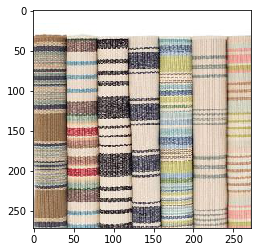

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)

In [100]:
im=img.convert('L')
import numpy as np
imdata=np.asarray(im)
#print "Shape of array is ", numpy.shape(imdata)

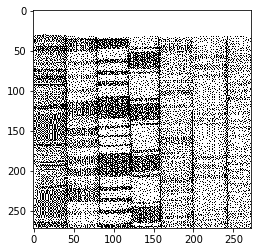

In [101]:
plt.imshow(Image.fromarray(imdata).convert('1'))

In [102]:
u,s,v=np.linalg.svd(imdata)

In [104]:
S=np.diag(s)        # s is 1d, this is how numpy reports s, np.diag makes it a size(s)*size(s) matrix with s as diagnol
var_or_eig=S.T.dot(S)  # this is nothing but eigen values of covariance matrix
var1d=np.diag(var_or_eig)     # to make it 1d from diagnol matrix, all other elements are zeors
var1dpct=var1d*100.0/sum(var1d)  #compute variance as percent

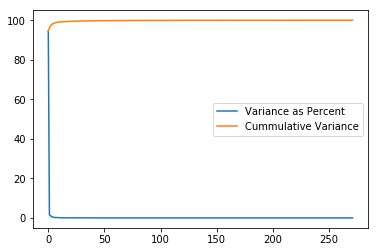

In [105]:
plt.plot(var1dpct,label="Variance as Percent")
plt.plot(var1dpct.cumsum(),label="Cummulative Variance")
plt.legend()

In [175]:
img_data_PC=np.zeros((5,272,272))
img_data_PC[0,:,:]=u[:,0::].dot(S[0::,0::]).dot(v[0::,:])
img_data_PC[1,:,:]=u[:,0:1].dot(S[0:1,0:1]).dot(v[0:1,:])
img_data_PC[2,:,:]=u[:,0:2].dot(S[0:2,0:2]).dot(v[0:2,:])-img_data_PC[1,:,:]
img_data_PC[3,:,:]=u[:,0:3].dot(S[0:3,0:3]).dot(v[0:3,:])-img_data_PC[1,:,:]-img_data_PC[2,:,:]

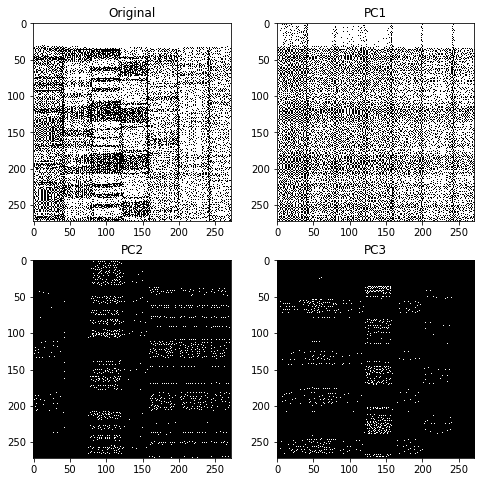

In [176]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2

kk=['Original','PC1', 'PC2', 'PC3'];
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(Image.fromarray(img_data_PC[i-1,:,:]).convert('1'))
    plt.title(kk[i-1])
plt.show()

#plt.imshow(Image.fromarray(img_data_1PC).convert('1'))
#plt.imshow(Image.fromarray(img_data_2PC).convert('1'))

### Using 10 PCs to reconstruct data

<function matplotlib.pyplot.tight_layout>

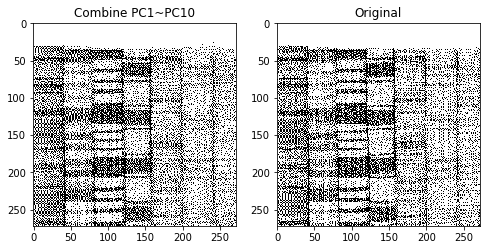

In [183]:
img_data_PC[4,:,:]=u[:,0:10].dot(S[0:10,0:10]).dot(v[0:10,:])

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(Image.fromarray(img_data_PC[4,:,:]).convert('1'))
plt.title('Combine PC1~PC10')

plt.subplot(122)
plt.imshow(Image.fromarray(img_data_PC[0,:,:]).convert('1'))
plt.title('Original')
plt.tight_layout

### Reconstructed figure by 10 PCs is pretty close to the original !